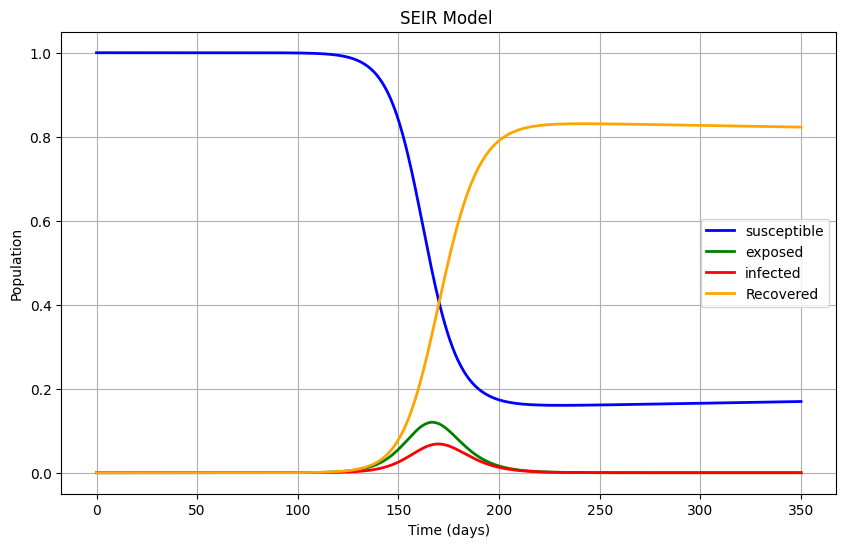

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
a1 = 0.70746202
a2 = 0.1876435
a3 = 0.31817251
a4 = 0.002942
a5 = 0.00000049234
a6 = a7 = 0.0001


# Initial conditions
S0 = 1
E0 = 0.000000002
I0 = 0.000000001
R0 = 0
N = S0 + E0 + I0 + R0        # total population
y0 = [S0 , E0 , I0 , R0]

# Define the system of ODEs
def sir_model(t, y, a1 ,a2 ,a3 ,a4 ,a5 ,a6 ,a7):
    S, E, I, R = y
    dS = a6  - a1 * S * I + a5 * R - a7 * S
    dE = a1 * S * I  - (a2 + a7) * E
    dI = a2 * E - (a3 + a4 + a7) * I
    dR = a3 * I - (a5 + a7) * R
    return [dS,dE,dI,dR]

# Solve ODE system
t_span = (0, 350)
t_eval = np.linspace(*t_span, 1000)   # dense output for plotting
params = (a1 ,a2 ,a3 ,a4 ,a5 ,a6 ,a7)
sol = solve_ivp(sir_model, t_span, y0, t_eval=t_eval, args=params , method='RK45')

plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[0], 'blue', label='susceptible', linewidth=2)
plt.plot(sol.t, sol.y[1], 'green', label='exposed', linewidth=2)
plt.plot(sol.t, sol.y[2], 'red', label='infected', linewidth=2)
plt.plot(sol.t, sol.y[3], 'orange', label='Recovered', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.legend()
plt.title('SEIR Model ')
plt.grid(True)
plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_14092\3146872787.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nigeria_conf.index = pd.to_datetime(nigeria_conf.index)
C:\Users\asus\AppData\Local\Temp\ipykernel_14092\3146872787.py:21: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nigeria_recv.index = pd.to_datetime(nigeria_recv.index)


`ftol` termination condition is satisfied.
Function evaluations 85, initial cost 4.6982e+06, final cost 3.0536e+04, first-order optimality 2.14e+02.


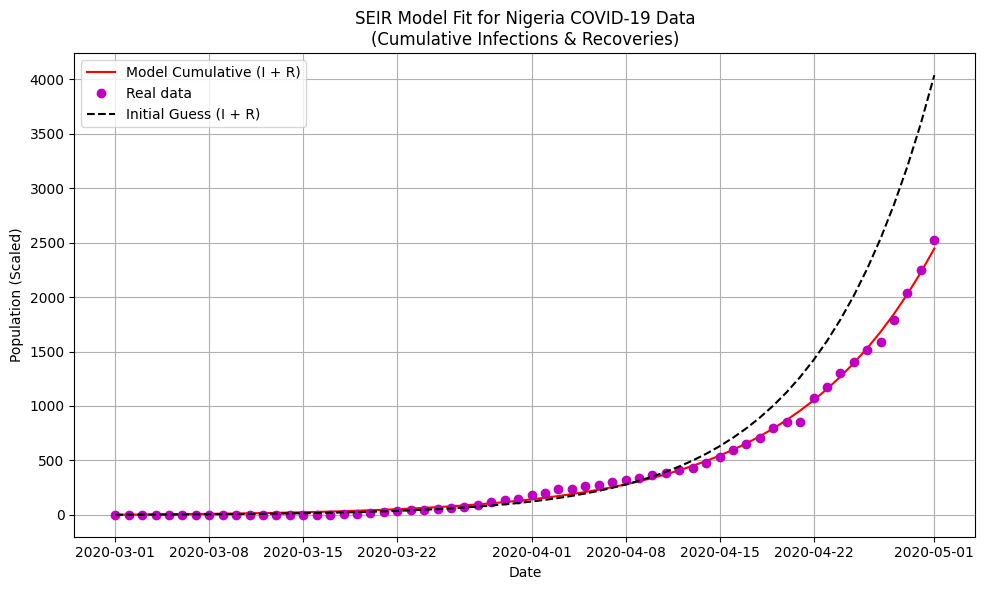


Estimated Parameters:
a1 = 0.6507310441
a2 = 0.5435791335
a3 = 0.4616872431
a4 = 0.0000003294
a5 = 0.0058295201
a6 = 0.0000067631

Basic Reproduction Number R0 = 1.4094


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

# -------------------------------
# 1. Load dataset
# -------------------------------
file_path_confirmed = "time_series_covid19_confirmed_global.csv"
file_path_recovered = "time_series_covid19_recovered_global.csv"

data_conf = pd.read_csv(file_path_confirmed)
data_recv = pd.read_csv(file_path_recovered)

# Select country (Nigeria)
nigeria_conf = data_conf[data_conf['Country/Region'] == 'Nigeria'].iloc[:, 4:].sum(axis=0)
nigeria_recv = data_recv[data_recv['Country/Region'] == 'Nigeria'].iloc[:, 4:].sum(axis=0)

nigeria_conf.index = pd.to_datetime(nigeria_conf.index)
nigeria_recv.index = pd.to_datetime(nigeria_recv.index)

# -------------------------------
# 2. Select fitting window
# -------------------------------
start_date = "2020-03-01"
end_date   = "2020-05-01"

real_cum_infect = nigeria_conf.loc[start_date:end_date].values
real_cum_recover = nigeria_recv.loc[start_date:end_date].values
real_cum = real_cum_infect + real_cum_recover
dates = nigeria_conf.loc[start_date:end_date].index
t_data = np.arange(len(dates))

# -------------------------------
# 3. SEIR model definition
# -------------------------------
def seir(t, y, params, N):
    S, E, I, R = y
    (a1, a2, a3, a4, a5, a6) = params
    dS_dt = a6 * N - a1 * S * I / N + a5 * R - a6 * S
    dE_dt = a1 * S * I / N - (a2 + a6) * E
    dI_dt = a2 * E - (a3 + a4 + a6) * I
    dR_dt = a3 * I - (a5 + a6) * R
    return [dS_dt, dE_dt, dI_dt, dR_dt]

# -------------------------------
# 4. Initial conditions
# -------------------------------
N = 1_000_000_000  # scaled population
I0 = 1
E0 = 2
R0 = 0
S0 = N - (E0 + I0 + R0)
y0 = [S0, E0, I0, R0]

# -------------------------------
# 5. Model simulation
# -------------------------------
def simulate_model(params):
    sol = solve_ivp(
        fun=lambda t, y: seir(t, y, params, N),
        t_span=(t_data[0], t_data[-1]),
        y0=y0,
        t_eval=t_data,
        method='RK45'
    )
    I = sol.y[2]
    R = sol.y[3]
    cumulative_infectious = I + R
    return cumulative_infectious , R

# -------------------------------
# 6. Residuals function (fit to cumulative infections only)
# -------------------------------
def residuals(params):
    cum_pred, _ = simulate_model(params)
    return cum_pred - real_cum

# -------------------------------
# 7. Parameter estimation
# -------------------------------
initial_params = [0.70746202, 0.1876435, 0.31817251, 0.002942, 0.00000049234, 0.0001]
bounds = (0, np.inf)

result = least_squares(residuals, initial_params, bounds=bounds, verbose=1)
fitted_params = result.x
fitted_cum, fitted_recov = simulate_model(fitted_params)
initial_cum, initial_recov = simulate_model(initial_params)

# -------------------------------
# 8. Plot results
# -------------------------------
plt.figure(figsize=(10, 6))

# Real data
# plt.plot(dates, real_cum_infect, 'go', label='Real Cumulative Infections')
# plt.plot(dates, real_cum_recover, 'bs', label='Real Recovered')

# Model predictions
plt.plot(dates, fitted_cum, 'r-', label='Model Cumulative (I + R)')
plt.plot(dates, real_cum, 'mo', label='Real data')
plt.plot(dates, initial_cum, 'k--', label='Initial Guess (I + R)')

plt.xlabel('Date')
plt.ylabel('Population (Scaled)')
plt.title('SEIR Model Fit for Nigeria COVID-19 Data\n(Cumulative Infections & Recoveries)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# -------------------------------
# 9. Output fitted parameters
# -------------------------------
param_names = ["a1", "a2", "a3", "a4", "a5", "a6"]
print("\nEstimated Parameters:")
for name, val in zip(param_names, fitted_params):
    print(f"{name} = {val:.10f}")

# -----------------------------------
# 10. Compute R0
# -----------------------------------
a1, a2, a3, a4, a5, a6 = fitted_params

R0 = (a1 * a2) / ((a2 + a6) * (a3 + a4 + a6))

print(f"\nBasic Reproduction Number R0 = {R0:.4f}")


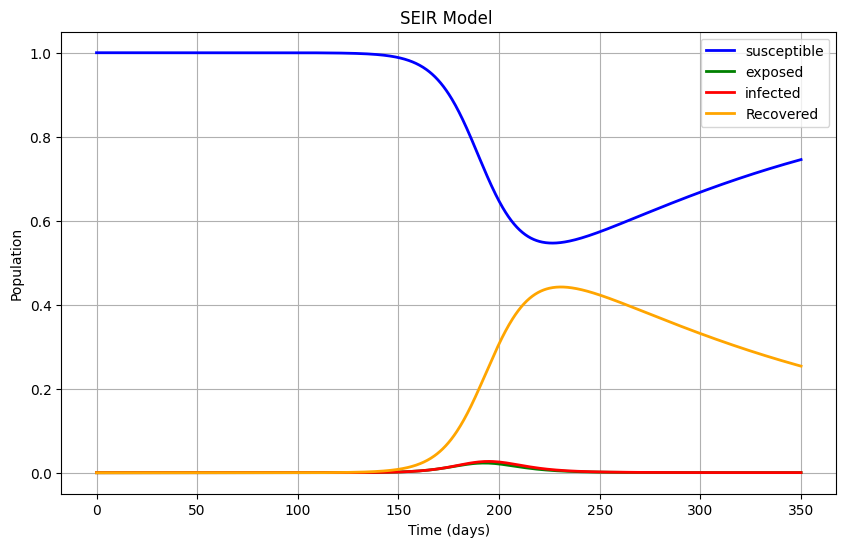

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
a1 = 0.6507310441
a2 = 0.5435791335
a3 = 0.4616872431
a4 = 0.0000003294
a5 = 0.0058295201
a6 = a7= 0.0000067631


# Initial conditions
S0 = 1
E0 = 0.000000002
I0 = 0.000000001
R0 = 0
N = S0 + E0 + I0 + R0        # total population
y0 = [S0 , E0 , I0 , R0]

# Define the system of ODEs
def sir_model(t, y, a1 ,a2 ,a3 ,a4 ,a5 ,a6 ,a7):
    S, E, I, R = y
    dS = a6  - a1 * S * I + a5 * R - a7 * S
    dE = a1 * S * I  - (a2 + a7) * E
    dI = a2 * E - (a3 + a4 + a7) * I
    dR = a3 * I - (a5 + a7) * R
    return [dS,dE,dI,dR]

# Solve ODE system
t_span = (0, 350)
t_eval = np.linspace(*t_span, 1000)   # dense output for plotting
params = (a1 ,a2 ,a3 ,a4 ,a5 ,a6 ,a7)
sol = solve_ivp(sir_model, t_span, y0, t_eval=t_eval, args=params , method='RK45')

plt.figure(figsize=(10,6))
plt.plot(sol.t, sol.y[0], 'blue', label='susceptible', linewidth=2)
plt.plot(sol.t, sol.y[1], 'green', label='exposed', linewidth=2)
plt.plot(sol.t, sol.y[2], 'red', label='infected', linewidth=2)
plt.plot(sol.t, sol.y[3], 'orange', label='Recovered', linewidth=2)
plt.xlabel('Time (days)')
plt.ylabel('Population')
plt.legend()
plt.title('SEIR Model ')
plt.grid(True)
plt.show()

C:\Users\asus\AppData\Local\Temp\ipykernel_5616\2136983892.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nigeria_conf.index = pd.to_datetime(nigeria_conf.index)
C:\Users\asus\AppData\Local\Temp\ipykernel_5616\2136983892.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  nigeria_recv.index = pd.to_datetime(nigeria_recv.index)


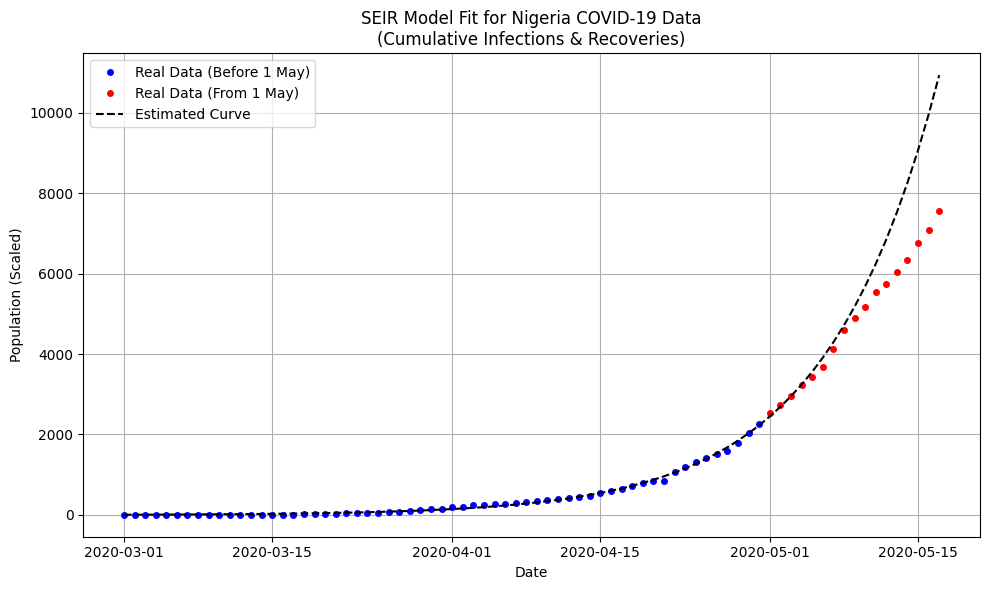

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# -------------------------------
# 1. Load dataset
# -------------------------------
file_path_confirmed = "time_series_covid19_confirmed_global.csv"
file_path_recovered = "time_series_covid19_recovered_global.csv"

data_conf = pd.read_csv(file_path_confirmed)
data_recv = pd.read_csv(file_path_recovered)

# Select country (Nigeria)
nigeria_conf = data_conf[data_conf['Country/Region'] == 'Nigeria'].iloc[:, 4:].sum(axis=0)
nigeria_recv = data_recv[data_recv['Country/Region'] == 'Nigeria'].iloc[:, 4:].sum(axis=0)

nigeria_conf.index = pd.to_datetime(nigeria_conf.index)
nigeria_recv.index = pd.to_datetime(nigeria_recv.index)

# -------------------------------
# 2. Select fitting window
# -------------------------------
start_date = "2020-03-01"
end_date   = "2020-05-17"

real_cum_infect = nigeria_conf.loc[start_date:end_date].values
real_cum_recover = nigeria_recv.loc[start_date:end_date].values
real_cum = real_cum_infect + real_cum_recover
dates = nigeria_conf.loc[start_date:end_date].index
t_data = np.arange(len(dates))

# -------------------------------
# 3. SEIR model definition
# -------------------------------
def seir(t, y, params, N):
    S, E, I, R = y
    (a1, a2, a3, a4, a5, a6) = params
    dS_dt = a6 * N - a1 * S * I / N + a5 * R - a6 * S
    dE_dt = a1 * S * I / N - (a2 + a6) * E
    dI_dt = a2 * E - (a3 + a4 + a6) * I
    dR_dt = a3 * I - (a5 + a6) * R
    return [dS_dt, dE_dt, dI_dt, dR_dt]

# -------------------------------
# 4. Initial conditions
# -------------------------------
N = 1_000_000_000  # scaled population
I0 = 1
E0 = 2
R0 = 0
S0 = N - (E0 + I0 + R0)
y0 = [S0, E0, I0, R0]

# -------------------------------
# 5. Model simulation
# -------------------------------
def simulate_model(params):
    sol = solve_ivp(
        fun=lambda t, y: seir(t, y, params, N),
        t_span=(t_data[0], t_data[-1]),
        y0=y0,
        t_eval=t_data,
        method='RK45'
    )
    I = sol.y[2]
    R = sol.y[3]
    cumulative_infectious = I + R
    return cumulative_infectious , R

# -------------------------------
# 6. Residuals function (fit to cumulative infections only)
# -------------------------------
def residuals(params):
    cum_pred, _ = simulate_model(params)
    return cum_pred - real_cum

# -------------------------------
# 7. Parameter estimation
# -------------------------------
initial_params = [0.6507310441,0.5435791335,0.4616872431,0.0000003294,0.0058295201,0.0000067631]

initial_cum, initial_recov = simulate_model(initial_params)

# # -------------------------------
# # 8. Plot results
# # -------------------------------
# plt.figure(figsize=(10, 6))


# # Model predictions
# plt.plot(dates, real_cum, 'm--', label='Real data')
# plt.plot(dates, initial_cum, 'k--', label='Estimated Curve')

# plt.xlabel('Date')
# plt.ylabel('Population (Scaled)')
# plt.title('SEIR Model Fit for Nigeria COVID-19 Data\n(Cumulative Infections & Recoveries)')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()
# -------------------------------
# 8. Plot results (split at 1 May)
# -------------------------------
plt.figure(figsize=(10, 6))

# --- Split index for 1 May 2020 ---
split_date = pd.to_datetime("2020-05-01")

before_mask = dates < split_date
after_mask  = dates >= split_date

# --- Real data ---
plt.plot(dates[before_mask], real_cum[before_mask], 'bo', markersize=4,
         label='Real Data (Before 1 May)')
plt.plot(dates[after_mask], real_cum[after_mask], 'ro', markersize=4,
         label='Real Data (From 1 May)')

# --- Model prediction ---
plt.plot(dates, initial_cum, 'k--', label='Estimated Curve')

plt.xlabel('Date')
plt.ylabel('Population (Scaled)')
plt.title('SEIR Model Fit for Nigeria COVID-19 Data\n(Cumulative Infections & Recoveries)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



C:\Users\asus\AppData\Local\Temp\ipykernel_12580\232183867.py:19: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  india_conf.index = pd.to_datetime(india_conf.index)
C:\Users\asus\AppData\Local\Temp\ipykernel_12580\232183867.py:20: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  india_recv.index = pd.to_datetime(india_recv.index)


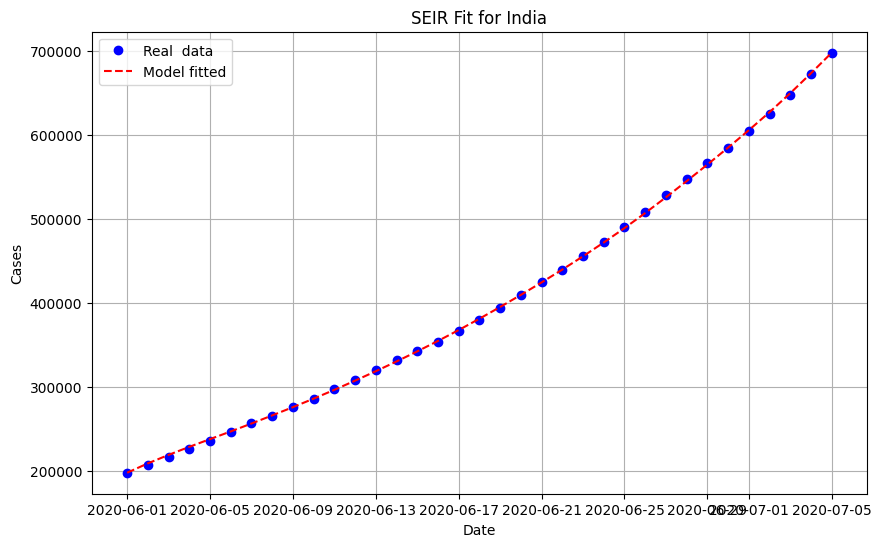


Estimated Parameters:
a1 = 0.37605099
a2 = 0.16675411
a3 = 0.27354472
a4 = 0.00000012
a5 = 0.00000010
a6 = 0.00000010

Basic Reproduction Number R0 = 1.3747


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import least_squares

# -------------------------------
# 1. Load dataset
# -------------------------------
file_path_confirmed = "time_series_covid19_confirmed_global.csv"
file_path_recovered = "time_series_covid19_recovered_global.csv"

data_conf = pd.read_csv(file_path_confirmed)
data_recv = pd.read_csv(file_path_recovered)

india_conf = data_conf[data_conf['Country/Region'] == 'India'].iloc[:, 4:].sum(axis=0)
india_recv = data_recv[data_recv['Country/Region'] == 'India'].iloc[:, 4:].sum(axis=0)

india_conf.index = pd.to_datetime(india_conf.index)
india_recv.index = pd.to_datetime(india_recv.index)

# -------------------------------
# 2. Fitting window
# -------------------------------
start_date = "2020-06-01"
end_date   = "2020-07-05"

real_cum_infect = india_conf.loc[start_date:end_date].values
real_cum_recover = india_recv.loc[start_date:end_date].values

dates = india_conf.loc[start_date:end_date].index
t_data = np.arange(len(dates))

# -------------------------------
# 3. SEIR model (unchanged)
# -------------------------------
def seir(t, y, params, N):
    S, E, I, R = y
    a1, a2, a3, a4, a5, a6 = params

    dS = a6*N - a1*S*I/N + a5*R - a6*S
    dE = a1*S*I/N - (a2 + a6)*E
    dI = a2*E - (a3 + a4 + a6)*I
    dR = a3*I - (a5 + a6)*R

    return [dS, dE, dI, dR]

# -------------------------------
# 4. Initial conditions
# -------------------------------
N = 1_378196571

I0 = 198370
E0 = I0*2
R0 = 95754
S0 = N - I0 - E0 - R0

y0 = [S0, E0, I0, R0]

# -------------------------------
# 5. Simulation
# -------------------------------
def simulate_model(params):
    sol = solve_ivp(lambda t, y: seir(t, y, params, N),
                    [t_data[0], t_data[-1]],
                    y0,
                    t_eval=t_data)
    I = sol.y[2]
    R = sol.y[3]
    return I , R

# -------------------------------
# 6. Residuals
# -------------------------------
def residuals(params):
    pred, _ = simulate_model(params)
    return pred - real_cum_infect

# -------------------------------
# 7. Parameter estimation
# -------------------------------
initial_params = [0.4, 0.3, 0.1, 0.01, 0.001, 0.0001]

lower_bounds = [1e-6, 1e-6, 1e-6, 1e-7, 1e-7, 1e-7]
upper_bounds = [2,     1,     1,     1,     0.1,   0.01]

result = least_squares(residuals, initial_params, bounds=(lower_bounds, upper_bounds))
fitted_params = result.x

fitted_cum, _ = simulate_model(fitted_params)

# -------------------------------
# 8. Plot
# -------------------------------
plt.figure(figsize=(10,6))
plt.plot(dates, real_cum_infect, 'bo', label="Real  data")
plt.plot(dates, fitted_cum, 'r--', label="Model fitted")

plt.title("SEIR Fit for India")
plt.xlabel("Date")
plt.ylabel("Cases")
plt.legend()
plt.grid(True)
plt.show()

# -------------------------------
# 9. Print parameters
# -------------------------------
names = ["a1","a2","a3","a4","a5","a6"]
print("\nEstimated Parameters:")
for n, v in zip(names, fitted_params):
    print(f"{n} = {v:.8f}")

# -----------------------------------
# 10. Compute R0
# -----------------------------------
a1, a2, a3, a4, a5, a6 = fitted_params

R0 = (a1 * a2) / ((a2 + a6) * (a3 + a4 + a6))

print(f"\nBasic Reproduction Number R0 = {R0:.4f}")

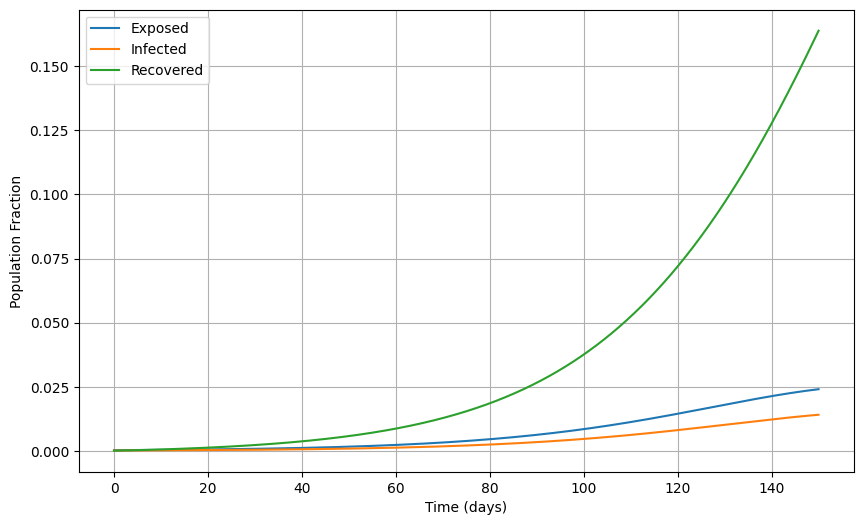

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Parameters
a1 = 0.37605020
a2 = 0.16675360
a3 = 0.27354389
a4 = 0.00000011
a5 = 0.00000019
a6 = a7 = 0.00000010
# Initial conditions (NORMALIZED)
N = 1_378_196_571

I0 = 198370 / N
E0 = 2 * I0
R0 = 95754 / N
S0 = 1 - I0 - E0 - R0   # <-- FIXED

y0 = [S0, E0, I0, R0]

# SEIR model
def seir_model(t, y):
    S, E, I, R = y
    dS = a6 - a1 * S * I + a5 * R - a7 * S
    dE = a1 * S * I - (a2 + a7) * E
    dI = a2 * E - (a3 + a4 + a7) * I
    dR = a3 * I - (a5 + a7) * R
    return [dS, dE, dI, dR]

# Time span
t_span = (0, 150)
t_eval = np.linspace(0, 150, 3000)  # fewer points = faster

# Solve
sol = solve_ivp(
    seir_model,
    t_span,
    y0,
    method='RK45',
    t_eval=t_eval,
    rtol=1e-6,
    atol=1e-9
)

# Plot
plt.figure(figsize=(10,6))
#plt.plot(sol.t , sol.y[0] , label='Susceptible')
plt.plot(sol.t, sol.y[1], label='Exposed')
plt.plot(sol.t, sol.y[2], label='Infected')
plt.plot(sol.t, sol.y[3], label='Recovered')
plt.xlabel('Time (days)')
plt.ylabel('Population Fraction')
plt.legend()
plt.grid()
plt.show()
